**A. IMPORTS/UTILITIES**

1.Imports and Dependencies

---



Description: Essential library imports for numerical computing, data handling, and machine learning utilities. Includes NumPy for core computations, pandas for data manipulation, and sklearn components for dataset loading and evaluation metrics.

2.Utility Functions

---



Description: Helper functions for reproducibility, data preprocessing, and dataset splitting.

2.1 Reproducibility Setup

---



set_seed(): Sets random seed for consistent results across runs

2.2 Data Splitting

---



train_val_test_split(): Custom stratified train/validation/test split implementation using pure NumPy, with optional stratification by class labels

2.3 Data Standardization

---



standardize_fit(): Computes mean and standard deviation for feature scaling
standardize_transform(): Applies z-score normalization using pre-computed statistics

In [1]:
# Core imports (keep it minimal)
import numpy as np
import pandas as pd

# For dataset convenience in demos only (model is pure NumPy)
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as sk_shuffle

# Reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

def train_val_test_split(X, y, val_size=0.1, test_size=0.2, stratify=True, seed=42):
    """
    Simple splitter in NumPy to avoid relying on sklearn's split.
    Keeps stratification by label if requested.
    """
    rng = np.random.default_rng(seed)
    if stratify:
        classes, y_idx = np.unique(y, return_inverse=True)
        X_tr, y_tr, X_va, y_va, X_te, y_te = [], [], [], [], [], []
        for c in range(len(classes)):
            idx = np.where(y_idx == c)[0]
            rng.shuffle(idx)
            n = len(idx)
            n_test = int(round(test_size * n))
            n_val  = int(round(val_size * (n - n_test)))
            te_idx = idx[:n_test]
            va_idx = idx[n_test:n_test+n_val]
            tr_idx = idx[n_test+n_val:]
            X_te.append(X[te_idx]); y_te.append(y[te_idx])
            X_va.append(X[va_idx]); y_va.append(y[va_idx])
            X_tr.append(X[tr_idx]); y_tr.append(y[tr_idx])
        X_tr = np.concatenate(X_tr); y_tr = np.concatenate(y_tr)
        X_va = np.concatenate(X_va); y_va = np.concatenate(y_va)
        X_te = np.concatenate(X_te); y_te = np.concatenate(y_te)
    else:
        n = X.shape[0]
        idx = np.arange(n)
        rng.shuffle(idx)
        n_test = int(round(test_size * n))
        n_val  = int(round(val_size * (n - n_test)))
        te_idx = idx[:n_test]
        va_idx = idx[n_test:n_test+n_val]
        tr_idx = idx[n_test+n_val:]
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        X_te, y_te = X[te_idx], y[te_idx]
    return X_tr, y_tr, X_va, y_va, X_te, y_te

def standardize_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-8
    return mu, sd

def standardize_transform(X, mu, sd):
    return (X - mu) / sd

**B. numpy core on breast cancer**

3.Dataset Loading and Preprocessing

---



Description: Loads the breast cancer dataset, performs proper train/validation/test splitting with stratification, and applies standardization while preventing data leakage.

3.1 Dataset Preparation

---



Loads breast cancer dataset from sklearn
Converts data types and reshapes target variable
Applies stratified splitting to maintain class balance across splits

3.2 Feature Standardization

---



Fits standardization parameters on training data only
Transforms all splits using training statistics to prevent data leakage

4.Neural Network Implementation

---



Description: Pure NumPy implementation of a single hidden layer Multi-Layer Perceptron (MLP) with ReLU and Sigmoid activation functions.

4.1 Activation Functions

---



relu(): ReLU activation function
relu_deriv(): ReLU derivative for backpropagation
sigmoid(): Sigmoid activation for binary classification output

4.2 Weight Initialization

---



he_init(): He initialization for ReLU layers
xavier_init(): Xavier initialization for sigmoid output layer

4.3 Network Architecture Setup

---



Defines 1 hidden layer with 16 neurons
Initializes weights and biases for input→hidden and hidden→output layers

4.4 Forward and Backward Propagation

---



forward(): Forward pass with caching for backpropagation
bce_loss(): Binary cross-entropy loss function
backward(): Backpropagation with gradient computation

5.Model Training and Evaluation

---



Description: Training loop with mini-batch SGD, early stopping, and final model evaluation.

5.1 Training Configuration

---



Sets hyperparameters: learning rate, batch size, epochs, early stopping patience

5.2 Training Loop

---



Mini-batch training with data shuffling
Early stopping based on validation loss
Progress monitoring with accuracy metrics

5.3 Final Evaluation

---



Restores best model weights
Evaluates final performance on held-out test set

In [2]:
set_seed(42)

# Load dataset
bc = load_breast_cancer()
X = bc.data.astype(np.float64)
y = bc.target.astype(np.int64).reshape(-1, 1)  # column vector

# Split (train/val/test) with stratification; NO standardization yet (avoid leakage)
X_tr, y_tr, X_va, y_va, X_te, y_te = train_val_test_split(
    X, y, val_size=0.1, test_size=0.2, stratify=True, seed=42
)

# Fit scaler on TRAIN only, then transform all splits (prevents leakage)
mu, sd = standardize_fit(X_tr)
X_tr = standardize_transform(X_tr, mu, sd)
X_va = standardize_transform(X_va, mu, sd)
X_te = standardize_transform(X_te, mu, sd)

# ----- Minimal MLP (1 hidden layer, ReLU -> Sigmoid), pure NumPy -----

def relu(z): return np.maximum(0, z)
def relu_deriv(z): return (z > 0).astype(z.dtype)
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def he_init(in_dim, out_dim):
    return np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)

def xavier_init(in_dim, out_dim):
    return np.random.randn(in_dim, out_dim) * np.sqrt(1.0 / in_dim)

# Architecture
in_dim = X_tr.shape[1]
h_dim  = 16
out_dim = 1

W1 = he_init(in_dim, h_dim)
b1 = np.zeros((1, h_dim))
W2 = xavier_init(h_dim, out_dim)
b2 = np.zeros((1, out_dim))

def forward(X):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)
    cache = (X, Z1, A1, Z2, A2)
    return A2, cache

def bce_loss(y_true, y_pred):
    eps = 1e-9
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

def backward(cache, y_true):
    X, Z1, A1, Z2, A2 = cache
    m = X.shape[0]
    dZ2 = (A2 - y_true)             # dL/dZ2 for sigmoid + BCE
    dW2 = (A1.T @ dZ2) / m
    db2 = dZ2.mean(axis=0, keepdims=True)
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = (X.T @ dZ1) / m
    db1 = dZ1.mean(axis=0, keepdims=True)
    return dW1, db1, dW2, db2

# Training (mini-batch, shuffling, early stopping on val)
lr = 0.05
batch_size = 32
epochs = 300
patience = 20
best_val = np.inf
best_state = None
wait = 0

for epoch in range(1, epochs+1):
    Xs, ys = sk_shuffle(X_tr, y_tr, random_state=42+epoch)
    # mini-batches
    for i in range(0, Xs.shape[0], batch_size):
        xb = Xs[i:i+batch_size]
        yb = ys[i:i+batch_size]
        yhat, cache = forward(xb)
        dW1, db1, dW2, db2 = backward(cache, yb)
        # SGD step
        W1 -= lr * dW1; b1 -= lr * db1
        W2 -= lr * dW2; b2 -= lr * db2

    # monitor
    with np.errstate(over='ignore'):
        yhat_tr, _ = forward(X_tr)
        yhat_va, _ = forward(X_va)
    tr_loss = bce_loss(y_tr, yhat_tr)
    va_loss = bce_loss(y_va, yhat_va)

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        best_state = (W1.copy(), b1.copy(), W2.copy(), b2.copy())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop at epoch {epoch}, best val loss {best_val:.4f}")
            break

    if epoch % 20 == 0 or epoch == 1:
        tr_acc = accuracy_score(y_tr, (yhat_tr > 0.5).astype(int))
        va_acc = accuracy_score(y_va, (yhat_va > 0.5).astype(int))
        print(f"Epoch {epoch:03d} | loss(tr)={tr_loss:.4f} acc(tr)={tr_acc:.3f} | loss(va)={va_loss:.4f} acc(va)={va_acc:.3f}")

# Restore best and evaluate on test
W1, b1, W2, b2 = best_state
yhat_te, _ = forward(X_te)
te_acc = accuracy_score(y_te, (yhat_te > 0.5).astype(int))
print(f"Test Accuracy: {te_acc*100:.2f}%")

Epoch 001 | loss(tr)=0.3468 acc(tr)=0.920 | loss(va)=0.2944 acc(va)=0.957
Epoch 020 | loss(tr)=0.0767 acc(tr)=0.978 | loss(va)=0.0538 acc(va)=0.978
Epoch 040 | loss(tr)=0.0539 acc(tr)=0.988 | loss(va)=0.0366 acc(va)=1.000
Epoch 060 | loss(tr)=0.0438 acc(tr)=0.988 | loss(va)=0.0303 acc(va)=1.000
Epoch 080 | loss(tr)=0.0365 acc(tr)=0.993 | loss(va)=0.0283 acc(va)=1.000
Epoch 100 | loss(tr)=0.0313 acc(tr)=0.993 | loss(va)=0.0268 acc(va)=1.000
Epoch 120 | loss(tr)=0.0275 acc(tr)=0.995 | loss(va)=0.0264 acc(va)=1.000
Early stop at epoch 135, best val loss 0.0262
Test Accuracy: 97.35%


**C. pytorch like lib**

6.Custom Neural Network Framework

---



Description: A lightweight, NumPy-based deep learning framework with modular design patterns similar to PyTorch/Keras, providing reusable components for building and training neural networks.

6.1 Base Module Class

---



Module: Abstract base class defining the interface for all neural network layers
Establishes forward/backward propagation contract and parameter management

6.2 Dense Layer Implementation

---



Dense: Fully connected layer with configurable activation functions
Features:

Multiple activation options: ReLU, Sigmoid, Softmax, Linear
Automatic weight initialization (He, Xavier, or auto-selection)
Built-in gradient computation and caching
Parameter and gradient tracking for optimization



6.3 Loss Functions

---



BinaryCrossEntropy: Loss function for binary classification with gradient computation
CategoricalCrossEntropy: Loss function for multi-class classification with one-hot encoding support
Both classes provide numerically stable implementations with epsilon smoothing

6.4 Optimizer

---



SGD: Stochastic Gradient Descent optimizer with optional L2 weight decay
Handles parameter updates across all model layers

6.5 Model Container

---



Sequential: High-level model interface for stacking layers sequentially
Key Methods:

add(): Add layers to the model
compile(): Configure loss function and optimizer
fit(): Training loop with validation, early stopping, and progress monitoring
predict(): Inference with automatic thresholding for binary/multi-class tasks


Training Features:

---



Mini-batch processing with shuffling
Early stopping based on validation loss
Automatic model state restoration to best weights

In [3]:
# ===== Tiny NumPy "framework" =====

class Module:
    def forward(self, X): raise NotImplementedError
    def backward(self, grad_out): raise NotImplementedError
    def params_and_grads(self):
        # Yield (param_array, grad_array) pairs if layer has trainable params
        return []

class Dense(Module):
    def __init__(self, in_dim, out_dim, activation=None, init="auto"):
        self.in_dim, self.out_dim = in_dim, out_dim
        self.activation = activation  # 'relu', 'sigmoid', None, 'softmax' (softmax only for output)
        if init == "auto":
            if activation == "relu":
                scale = np.sqrt(2.0 / in_dim)
            else:
                scale = np.sqrt(1.0 / in_dim)
        elif init == "he":
            scale = np.sqrt(2.0 / in_dim)
        elif init == "xavier":
            scale = np.sqrt(1.0 / in_dim)
        else:
            raise ValueError("Unknown init")
        self.W = np.random.randn(in_dim, out_dim) * scale
        self.b = np.zeros((1, out_dim))
        # caches
        self.X = None; self.Z = None; self.A = None
        # grads
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def _relu(self, z): return np.maximum(0, z)
    def _relu_grad(self, z): return (z > 0).astype(z.dtype)
    def _sigmoid(self, z): return 1.0 / (1.0 + np.exp(-z))
    # Softmax only for output use; gradient handled in loss for numerical stability.

    def forward(self, X):
        self.X = X
        self.Z = X @ self.W + self.b
        if self.activation == "relu":
            self.A = self._relu(self.Z)
        elif self.activation == "sigmoid":
            self.A = self._sigmoid(self.Z)
        elif self.activation in (None, "linear"):
            self.A = self.Z
        elif self.activation == "softmax":
            # softmax per row
            Zs = self.Z - self.Z.max(axis=1, keepdims=True)
            ex = np.exp(Zs)
            self.A = ex / np.clip(ex.sum(axis=1, keepdims=True), 1e-12, None)
        else:
            raise ValueError("Unknown activation")
        return self.A

    def backward(self, grad_out):
        # grad_out is dL/dA
        if self.activation == "relu":
            grad_act = self._relu_grad(self.Z)
            grad_z = grad_out * grad_act
        elif self.activation in ("sigmoid", None, "linear", "softmax"):
            # For sigmoid+binary CE and softmax+CE we pass correct grad from loss,
            # so here just propagate linear gradient.
            grad_z = grad_out
        else:
            raise ValueError("Unknown activation")

        m = self.X.shape[0]
        self.dW = (self.X.T @ grad_z) / m
        self.db = grad_z.mean(axis=0, keepdims=True)
        grad_in = grad_z @ self.W.T
        return grad_in

    def params_and_grads(self):
        yield self.W, self.dW
        yield self.b, self.db

class BinaryCrossEntropy:
    def loss(self, y_true, y_pred):
        eps = 1e-9
        return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))
    def grad(self, y_true, y_pred):
        # dL/dy_pred for sigmoid output with BCE
        eps = 1e-9
        return (y_pred - y_true) / np.clip(y_pred*(1-y_pred), eps, None)

class CategoricalCrossEntropy:
    def loss(self, y_true_onehot, y_pred_softmax):
        eps = 1e-9
        return -np.mean(np.sum(y_true_onehot * np.log(y_pred_softmax + eps), axis=1))
    def grad(self, y_true_onehot, y_pred_softmax):
        # With softmax + CE, dL/dz = (y_pred - y_true)
        return (y_pred_softmax - y_true_onehot)

class SGD:
    def __init__(self, lr=1e-2, weight_decay=0.0):
        self.lr = lr
        self.wd = weight_decay

    def step(self, model):
        for layer in model.layers:
            for P, dP in layer.params_and_grads():
                if self.wd > 0:  # L2
                    dP = dP + self.wd * P
                P -= self.lr * dP

class Sequential:
    def __init__(self): self.layers = []
    def add(self, layer): self.layers.append(layer)

    def compile(self, loss, optimizer):
        self.loss_fn = loss
        self.opt = optimizer

    def forward(self, X):
        out = X
        for l in self.layers: out = l.forward(out)
        return out

    def fit(self, X, y, epochs=50, batch_size=64, X_val=None, y_val=None, verbose=1, patience=None, shuffle=True):
        n = X.shape[0]
        best = None; best_val = np.inf; wait = 0
        for ep in range(1, epochs+1):
            if shuffle:
                idx = np.random.permutation(n)
                Xs, ys = X[idx], y[idx]
            else:
                Xs, ys = X, y
            losses = []
            for i in range(0, n, batch_size):
                xb = Xs[i:i+batch_size]; yb = ys[i:i+batch_size]
                yhat = self.forward(xb)
                loss = self.loss_fn.loss(yb, yhat)
                losses.append(loss)
                # backward: start from dL/dout
                grad = self.loss_fn.grad(yb, yhat)
                for l in reversed(self.layers):
                    grad = l.backward(grad)
                self.opt.step(self)
            log = f"Epoch {ep:03d} | loss={np.mean(losses):.4f}"
            if X_val is not None and y_val is not None:
                yhat_val = self.forward(X_val)
                val_loss = self.loss_fn.loss(y_val, yhat_val)
                log += f" | val_loss={val_loss:.4f}"
                # early stopping (min val loss)
                if patience is not None:
                    if val_loss < best_val - 1e-6:
                        best_val = val_loss; wait = 0
                        best = [ (l.W.copy(), l.b.copy()) if isinstance(l, Dense) else None for l in self.layers ]
                    else:
                        wait += 1
                        if wait >= patience:
                            print(log + " | early stop")
                            # restore best
                            if best is not None:
                                j = 0
                                for idx, l in enumerate(self.layers):
                                    if isinstance(l, Dense):
                                        l.W, l.b = best[j]
                                        j += 1
                            return
            if verbose:
                print(log)

    def predict(self, X, threshold=0.5):
        out = self.forward(X)
        if out.shape[1] == 1:
            return (out > threshold).astype(int)
        else:
            return out.argmax(axis=1, keepdims=True)

**D. demo on breast cancer**

7.Model Training with Custom Framework

---



Description: Demonstrates the usage of the custom neural network framework by building, training, and evaluating a binary classification model on the breast cancer dataset.

7.1 Model Architecture Definition

---



Creates a Sequential model with the same architecture as the previous implementation
Layer Stack:

Input layer → Hidden layer (16 neurons, ReLU activation)
Hidden layer → Output layer (1 neuron, Sigmoid activation)



7.2 Model Configuration

---



Compiles model with Binary Cross-Entropy loss function
Configures SGD optimizer with learning rate 0.05 and L2 weight decay (1e-4)
Weight decay adds regularization to prevent overfitting

7.3 Training Process

---



Trains for up to 200 epochs with batch size of 32
Uses validation set for monitoring and early stopping (patience = 20)
Automatically restores best weights based on validation loss
Verbose output shows training progress

7.4 Model Evaluation

---



Makes predictions on test set using 0.5 threshold for binary classification
Calculates and reports final test accuracy
Demonstrates the framework's prediction capabilities

In [4]:
set_seed(42)

# Use the same preprocessed splits from Cell 2: X_tr, y_tr, X_va, y_va, X_te, y_te
# Build model: Dense(16, relu) -> Dense(1, sigmoid)
model = Sequential()
model.add(Dense(X_tr.shape[1], 16, activation="relu"))
model.add(Dense(16, 1, activation="sigmoid"))

model.compile(loss=BinaryCrossEntropy(), optimizer=SGD(lr=0.05, weight_decay=1e-4))
model.fit(X_tr, y_tr, epochs=200, batch_size=32, X_val=X_va, y_val=y_va, patience=20, verbose=1)

# Evaluate
y_pred_te = model.predict(X_te, threshold=0.5)
acc = (y_pred_te == y_te).mean()
print(f"Breast Cancer Test Accuracy (library): {acc*100:.2f}%")

Epoch 001 | loss=0.2594 | val_loss=0.0962
Epoch 002 | loss=2.9458 | val_loss=7.6586
Epoch 003 | loss=12.2853 | val_loss=18.9212
Epoch 004 | loss=11.8216 | val_loss=7.6586
Epoch 005 | loss=nan | val_loss=nan
Epoch 006 | loss=nan | val_loss=nan
Epoch 007 | loss=nan | val_loss=nan
Epoch 008 | loss=nan | val_loss=nan
Epoch 009 | loss=nan | val_loss=nan
Epoch 010 | loss=nan | val_loss=nan
Epoch 011 | loss=nan | val_loss=nan
Epoch 012 | loss=nan | val_loss=nan
Epoch 013 | loss=nan | val_loss=nan
Epoch 014 | loss=nan | val_loss=nan
Epoch 015 | loss=nan | val_loss=nan
Epoch 016 | loss=nan | val_loss=nan
Epoch 017 | loss=nan | val_loss=nan
Epoch 018 | loss=nan | val_loss=nan
Epoch 019 | loss=nan | val_loss=nan
Epoch 020 | loss=nan | val_loss=nan
Epoch 021 | loss=nan | val_loss=nan | early stop
Breast Cancer Test Accuracy (library): 96.46%


/tmp/ipython-input-3672346631.py:35: RuntimeWarning: overflow encountered in exp
  def _sigmoid(self, z): return 1.0 / (1.0 + np.exp(-z))
/tmp/ipython-input-3672346631.py:40: RuntimeWarning: overflow encountered in matmul
  self.Z = X @ self.W + self.b
/tmp/ipython-input-3672346631.py:71: RuntimeWarning: overflow encountered in matmul
  grad_in = grad_z @ self.W.T
/tmp/ipython-input-3672346631.py:69: RuntimeWarning: overflow encountered in matmul
  self.dW = (self.X.T @ grad_z) / m
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipython-input-3672346631.py:40: RuntimeWarning: invalid value encountered in matmul
  self.Z = X @ self.W + self.b


**-- DEMO confusion matrix**

8.Model Performance Analysis

---



Description: Implements confusion matrix analysis and visualization to evaluate the binary classification model's performance in detail.

8.1 Confusion Matrix Implementation

---



confusion_matrix_np(): Custom NumPy implementation for computing confusion matrix
Counts true positives, false positives, true negatives, and false negatives
Avoids sklearn dependency while providing essential evaluation functionality

8.2 Data Preparation

---



Flattens prediction arrays to ensure proper 1D format
Handles potential shape mismatches between true and predicted labels

8.3 Matrix Computation and Normalization

---



Computes raw confusion matrix with actual counts
Creates row-normalized version showing prediction rates per true class
Uses numerical stability with clipping to prevent division by zero

8.4 Visualization

---



Count Matrix Plot: Shows absolute numbers of correct/incorrect predictions
Normalized Matrix Plot: Displays prediction accuracy rates as percentages
Visual Features:

Blue color scheme with intensity representing values
Clear axis labels distinguishing Malignant (0) vs Benign (1) classes
Colorbars for interpreting matrix values
Professional formatting with tight layout


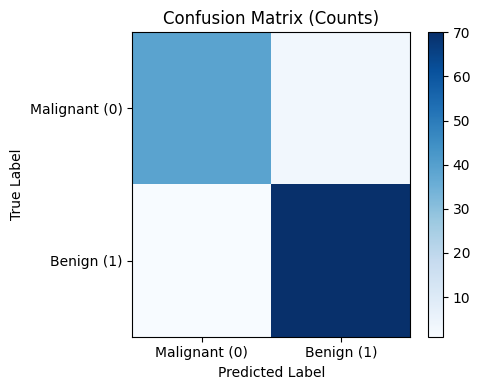

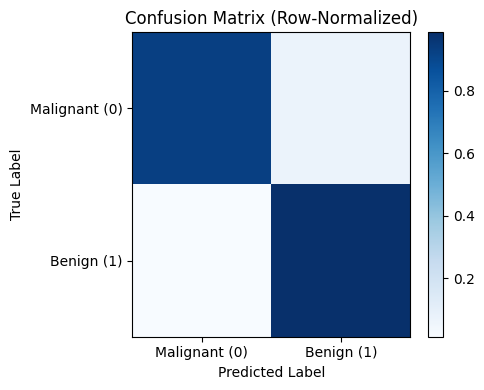

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix_np(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

# Make sure y_te and y_pred_te are 1D arrays of 0/1 labels
y_true = y_te.flatten()  # flatten in case it's (n,1)
y_pred = y_pred_te.flatten()

cm = confusion_matrix_np(y_true, y_pred)

# Normalize rows for better visualization
cm_norm = cm / np.clip(cm.sum(axis=1, keepdims=True), 1e-12, None)

# Plot counts
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", aspect="auto", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.xticks([0,1], ["Malignant (0)", "Benign (1)"])
plt.yticks([0,1], ["Malignant (0)", "Benign (1)"])
plt.tight_layout()
plt.show()

# Plot normalized
plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest", aspect="auto", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.xticks([0,1], ["Malignant (0)", "Benign (1)"])
plt.yticks([0,1], ["Malignant (0)", "Benign (1)"])
plt.tight_layout()
plt.show()


**E. MNIST utilies**

9.Data Preprocessing Utilities

---



Description: Additional utility functions for handling common machine learning data preprocessing tasks, particularly for multi-class classification and image data.

9.1 Label Encoding

---



to_one_hot(): Converts integer class labels to one-hot encoded vectors
Essential for multi-class classification with categorical cross-entropy loss
Handles automatic reshaping and type conversion for robustness

9.2 Image Preprocessing

---



scale_0_1(): Normalizes pixel values from [0, 255] range to [0, 1] range
Standard preprocessing step for image data in neural networks
Improves training stability and convergence speed

9.3 Image Flattening

---



flatten_images(): Reshapes multi-dimensional image arrays into 2D format
Converts (batch_size, height, width, channels) to (batch_size, features)
Required for feeding image data into fully connected layers

In [5]:
def to_one_hot(y, num_classes):
    y = y.astype(int).reshape(-1)
    oh = np.zeros((y.shape[0], num_classes), dtype=np.float64)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def scale_0_1(X):
    X = X.astype(np.float64)
    return X / 255.0

def flatten_images(X):
    return X.reshape(X.shape[0], -1)

**F. MNIST with softmax+CE**

10.MNIST Multi-Class Classification with Learning Rate Decay

---



Description: Complete implementation of a multi-class classification pipeline using MNIST handwritten digits dataset, featuring advanced training techniques including learning rate scheduling and weight decay regularization.

10.1 Dependencies and Safety Checks

---



Imports MNIST dataset from TensorFlow/Keras
Runtime validation to ensure custom framework components are available
Prevents execution errors due to missing dependencies

10.2 Self-Contained Utility Functions

---



Duplicates essential preprocessing functions for cell independence
Includes seed setting, one-hot encoding, image scaling, flattening, and stratified splitting
Ensures reproducibility and modularity

10.3 Advanced Optimizer Implementation

---



SGDWarmDecay: Enhanced SGD optimizer with learning rate scheduling
Features:

Exponential decay every N epochs
Configurable decay factor and minimum learning rate floor
Epoch tracking for automatic scheduling
Inherits from base SGD class for weight decay support



10.4 MNIST Dataset Preparation

---



Loads and preprocesses MNIST handwritten digits (60K train, 10K test)
Preprocessing Pipeline:

Pixel normalization to [0,1] range
Image flattening from 28×28 to 784-dimensional vectors
Stratified train/validation split (90%/10%)
One-hot encoding for 10-class classification



10.5 Neural Network Architecture

---



3-layer MLP Design:

Input: 784 features (flattened 28×28 images)
Hidden Layer 1: 128 neurons with ReLU activation
Hidden Layer 2: 64 neurons with ReLU activation
Output Layer: 10 neurons with Softmax activation


Uses Categorical Cross-Entropy loss for multi-class classification

10.6 Advanced Training Loop

---



Manual epoch implementation to integrate learning rate scheduling
Training Features:

Batch size: 128 samples
20 epochs with learning rate decay every 5 epochs
Real-time monitoring of training and validation loss
Learning rate tracking and display


Demonstrates integration of custom optimizer callbacks

10.7 Model Evaluation

---



Final test accuracy evaluation on held-out MNIST test set
Converts softmax probabilities to class predictions using argmax
Reports performance as percentage accuracy

In [7]:
# ==== Merged Cell: MNIST + LR Decay training run (replaces Cells 6 & 7) ====

import numpy as np
from tensorflow.keras.datasets import mnist

# --- Safety checks (require the tiny NumPy library from Cell 3) ---
try:
    Sequential, Dense, CategoricalCrossEntropy, SGD
except NameError as e:
    raise RuntimeError("Run the library cell (Cell 3) that defines Sequential/Dense/Losses/SGD before this cell.") from e

# --- Utilities (self-contained; no dependency on Cell 5) ---
def set_seed(seed=42):
    np.random.seed(seed)

def to_one_hot(y, num_classes):
    y = y.astype(int).reshape(-1)
    oh = np.zeros((y.shape[0], num_classes), dtype=np.float64)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def scale_0_1(X):
    X = X.astype(np.float64)
    return X / 255.0

def flatten_images(X):
    return X.reshape(X.shape[0], -1)

def train_val_test_split(X, y, val_size=0.1, test_size=0.0, stratify=True, seed=42):
    rng = np.random.default_rng(seed)
    if stratify:
        classes, y_idx = np.unique(y, return_inverse=True)
        X_tr, y_tr, X_va, y_va = [], [], [], []
        for c in range(len(classes)):
            idx = np.where(y_idx == c)[0]
            rng.shuffle(idx)
            n = len(idx)
            n_val = int(round(val_size * n))
            va_idx = idx[:n_val]
            tr_idx = idx[n_val:]
            X_va.append(X[va_idx]); y_va.append(y[va_idx])
            X_tr.append(X[tr_idx]); y_tr.append(y[tr_idx])
        X_tr = np.concatenate(X_tr); y_tr = np.concatenate(y_tr)
        X_va = np.concatenate(X_va); y_va = np.concatenate(y_va)
    else:
        n = X.shape[0]
        idx = np.arange(n)
        rng.shuffle(idx)
        n_val = int(round(val_size * n))
        va_idx = idx[:n_val]
        tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
    return X_tr, y_tr, X_va, y_va

# --- LR scheduler with decay (inherits from SGD defined in Cell 3) ---
class SGDWarmDecay(SGD):
    def __init__(self, lr=0.05, weight_decay=0.0, decay_every=5, decay_factor=0.5, min_lr=1e-3):
        super().__init__(lr=lr, weight_decay=weight_decay)
        self.initial_lr = lr
        self.decay_every = decay_every
        self.decay_factor = decay_factor
        self.min_lr = min_lr
        self.epoch = 0
    def on_epoch_end(self):
        self.epoch += 1
        if self.epoch % self.decay_every == 0:
            self.lr = max(self.lr * self.decay_factor, self.min_lr)

# --- Load & prep MNIST ---
set_seed(42)
(num_classes, input_dim) = (10, 28*28)

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = flatten_images(scale_0_1(X_train))
X_test  = flatten_images(scale_0_1(X_test))

# Validation split from training
X_tr, y_tr, X_va, y_va = train_val_test_split(X_train, y_train.reshape(-1,1), val_size=0.1, stratify=True, seed=42)
y_tr_oh = to_one_hot(y_tr, num_classes)
y_va_oh = to_one_hot(y_va, num_classes)

# --- Build model: 784 -> 128(ReLU) -> 64(ReLU) -> 10(Softmax) ---
opt = SGDWarmDecay(lr=0.05, weight_decay=5e-5, decay_every=5, decay_factor=0.5, min_lr=1e-3)
model_mnist_wd = Sequential()
model_mnist_wd.add(Dense(input_dim, 128, activation="relu"))
model_mnist_wd.add(Dense(128, 64, activation="relu"))
model_mnist_wd.add(Dense(64, 10, activation="softmax"))
model_mnist_wd.compile(loss=CategoricalCrossEntropy(), optimizer=opt)

# --- Train with manual epoch loop (to call on_epoch_end) ---
epochs = 20
batch = 128
n = X_tr.shape[0]

for ep in range(1, epochs+1):
    idx = np.random.permutation(n)
    Xs, ys = X_tr[idx], y_tr_oh[idx]
    losses = []
    for i in range(0, n, batch):
        xb = Xs[i:i+batch]; yb = ys[i:i+batch]
        yhat = model_mnist_wd.forward(xb)
        loss = model_mnist_wd.loss_fn.loss(yb, yhat)
        losses.append(loss)
        grad = model_mnist_wd.loss_fn.grad(yb, yhat)
        for l in reversed(model_mnist_wd.layers):
            grad = l.backward(grad)
        model_mnist_wd.opt.step(model_mnist_wd)
    opt.on_epoch_end()
    val_loss = model_mnist_wd.loss_fn.loss(y_va_oh, model_mnist_wd.forward(X_va))
    print(f"[Decay Loop] Epoch {ep:02d}: loss={np.mean(losses):.4f} | val_loss={val_loss:.4f} | lr={opt.lr:.4f}")

# --- Test evaluation ---
probs_test = model_mnist_wd.forward(X_test)
pred_test = probs_test.argmax(axis=1)
test_acc = (pred_test.reshape(-1,1) == y_test.reshape(-1,1)).mean()
print(f"MNIST Test Accuracy (NumPy MLP + LR decay): {test_acc*100:.2f}%")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[Decay Loop] Epoch 01: loss=0.6310 | val_loss=0.3540 | lr=0.0500
[Decay Loop] Epoch 02: loss=0.2956 | val_loss=0.3024 | lr=0.0500
[Decay Loop] Epoch 03: loss=0.2387 | val_loss=0.2421 | lr=0.0500
[Decay Loop] Epoch 04: loss=0.2019 | val_loss=0.2159 | lr=0.0500
[Decay Loop] Epoch 05: loss=0.1749 | val_loss=0.1910 | lr=0.0250
[Decay Loop] Epoch 06: loss=0.1544 | val_loss=0.1835 | lr=0.0250
[Decay Loop] Epoch 07: loss=0.1456 | val_loss=0.1730 | lr=0.0250
[Decay Loop] Epoch 08: loss=0.1380 | val_loss=0.1653 | lr=0.0250
[Decay Loop] Epoch 09: loss=0.1305 | val_loss=0.1609 | lr=0.0250
[Decay Loop] Epoch 10: loss=0.1240 | val_loss=0.1535 | lr=0.0125
[Decay Loop] Epoch 11: loss=0.1175 | val_loss=0.1501 | lr=0.0125
[Decay Loop] Epoch 12: loss=0.1145 | val_loss=0.1474 | lr=0.0125
[Decay Loop] Epoch 13: loss=0.1120 | val_loss=0.1456 | lr=0.0125
[Decay Loop] Epoch 14: loss=0.1094 | val_loss=0.1432 | lr=0.0125
[Decay Loop] Epoch 15: loss=0.1067 | va

**--- NMIST: confusion matrix**

11.MNIST Performance Analysis and Visualization

---



Description: Comprehensive confusion matrix analysis for the MNIST multi-class classification results, providing detailed insights into model performance across all 10 digit classes.

11.1 Multi-Class Confusion Matrix Implementation

---



confusion_matrix_np(): Extended version supporting configurable number of classes
Handles multi-class classification with 10×10 matrix for digits 0-9
Robust array reshaping to handle various input formats

11.2 Matrix Computation and Analysis

---



Computes raw confusion matrix showing actual prediction counts per class pair
Creates row-normalized version revealing per-class accuracy rates
Uses numerical stability techniques to prevent division by zero errors

11.3 Dual Visualization Strategy

---



Count Matrix Visualization:

Shows absolute numbers of predictions for each true/predicted class combination
Helps identify which digit pairs are most commonly confused
Useful for understanding model behavior in terms of sample distribution


Normalized Matrix Visualization:

Displays classification accuracy as percentages for each true class
Reveals per-class performance independent of class frequency
Critical for identifying systematic biases or weak spots in digit recognition



11.4 Visual Design Features

---



6×5 inch figure size optimized for 10×10 matrix readability
Clear axis labeling with digit numbers (0-9)
Color intensity mapping for intuitive interpretation
Professional formatting with colorbars and tight layout

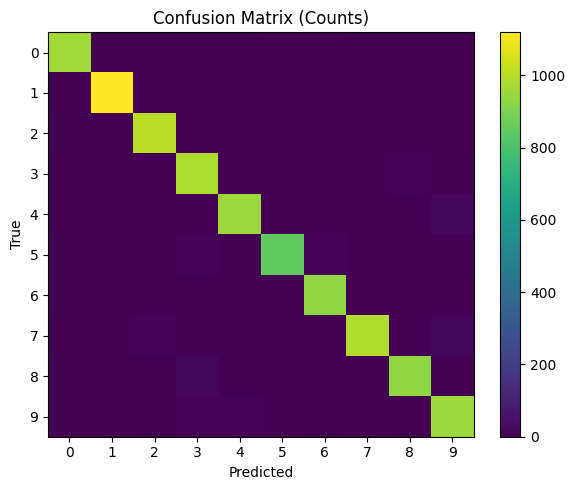

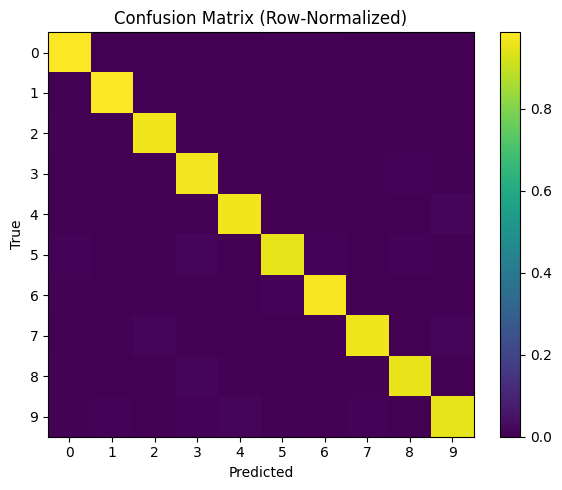

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def confusion_matrix_np(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true.reshape(-1), y_pred.reshape(-1)):
        cm[t, p] += 1
    return cm

cm = confusion_matrix_np(y_test, pred_test, num_classes=10)
cm_norm = cm / np.clip(cm.sum(axis=1, keepdims=True), 1e-12, None)

# Counts heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show()

# Normalized heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation="nearest", aspect="auto")
plt.title("Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show()


**--- NMIST misclassified**

12.Error Analysis Through Visual Inspection


---


Description: Visual examination of misclassified MNIST examples to understand model failure modes and identify challenging digit recognition cases.

12.1 Image Data Reshaping

---



Converts flattened test images back to original 28×28 pixel format
Enables proper visualization of digit images for human interpretation
Maintains correspondence between predictions and visual data

12.2 Misclassification Detection

---



Identifies all samples where predicted labels don't match true labels
Extracts indices of incorrectly classified examples for detailed analysis
Limits analysis to first 16 misclassified cases for focused examination

12.3 Visual Error Gallery

---



4×4 Grid Layout: Displays up to 16 misclassified examples in organized format
Image Rendering: Shows actual pixel data using nearest-neighbor interpolation
Dual Label Display: Each subplot shows both true label (T) and predicted label (P)
Clean Presentation: Removes axis ticks and labels for uncluttered digit viewing

12.4 Diagnostic Value

---


This visualization serves multiple analytical purposes:

Pattern Recognition: Helps identify systematic errors (e.g., consistently confusing 4s and 9s)
Data Quality Assessment: Reveals ambiguous or poorly written digits that even humans might misclassify
Model Limitations: Exposes specific visual features or writing styles the model struggles with
Improvement Direction: Guides potential model architecture or training modifications


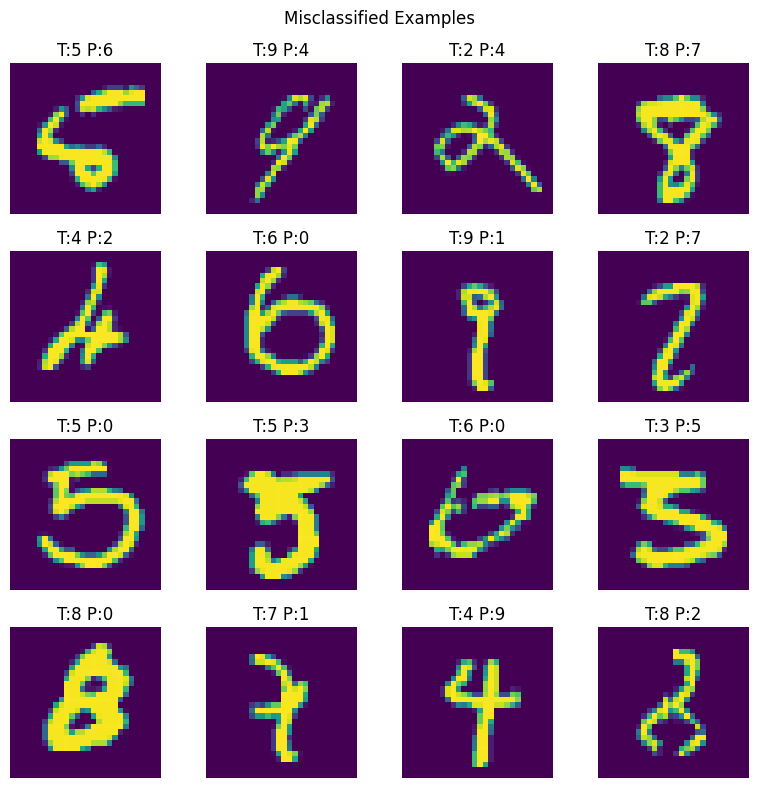

In [12]:
# We flattened X_test earlier; reshape to 28x28 for visualization.
X_test_img = X_test.reshape(-1, 28, 28)

mis_idx = np.where(pred_test.reshape(-1) != y_test.reshape(-1))[0]
k = min(16, len(mis_idx))
subset = mis_idx[:k]

plt.figure(figsize=(8, 8))
for i, idx in enumerate(subset):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_test_img[idx], interpolation="nearest")
    plt.title(f"T:{y_test[idx]} P:{pred_test[idx]}")
    plt.axis("off")
plt.suptitle("Misclassified Examples")
plt.tight_layout()
plt.show()

**--- NMIST per class precision /recall /f1+overall accuracy**

13.Comprehensive Classification Metrics Analysis

---



Description: Detailed per-class and aggregate performance evaluation using standard classification metrics derived from the confusion matrix.

13.1 Confusion Matrix Decomposition

---



Extracts fundamental classification components for each class:

True Positives (TP): Diagonal elements - correctly classified instances
False Positives (FP): Column sums minus TP - incorrectly predicted as this class
False Negatives (FN): Row sums minus TP - missed instances of this class
True Negatives (TN): Remaining cases - correctly rejected instances


Uses numerical stability with epsilon clipping to prevent division by zero

13.2 Per-Class Metrics Computation

---



Precision: TP/(TP+FP) - Accuracy of positive predictions for each class
Recall (Sensitivity): TP/(TP+FN) - Coverage of actual positive cases
F1-Score: Harmonic mean of precision and recall, balancing both metrics
All metrics computed independently for each of the 10 digit classes

13.3 Aggregate Performance Measures

---



Overall Accuracy: Total correct predictions across all classes
Macro Averages: Unweighted mean of per-class metrics

Treats all classes equally regardless of frequency
Reveals performance on minority classes
Important for balanced evaluation in multi-class scenarios



13.4 Formatted Results Display

---



Per-Class Table: Clean tabular presentation showing precision, recall, and F1 for digits 0-9
Summary Statistics: Overall accuracy and macro-averaged metrics
Professional formatting with consistent decimal precision and alignment

13.5 Analytical Value

---


This comprehensive metric analysis provides:

Class-Specific Insights: Identifies which digits are hardest to classify correctly
Balanced Assessment: Macro averaging prevents dominant classes from skewing results
Clinical Completeness: Standard metrics enable comparison with other classification approaches
Diagnostic Depth: Multiple metrics reveal different aspects of model performance (precision vs recall trade-offs)

In [9]:
eps = 1e-12
tp = np.diag(cm).astype(np.float64)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

precision = tp / np.clip(tp + fp, eps, None)
recall    = tp / np.clip(tp + fn, eps, None)
f1        = 2 * precision * recall / np.clip(precision + recall, eps, None)

macro_p = precision.mean()
macro_r = recall.mean()
macro_f1 = f1.mean()
acc = tp.sum() / cm.sum()

# Pretty print table
print("Class | Precision  Recall  F1")
for c in range(10):
    print(f"{c:>5} | {precision[c]:8.4f}  {recall[c]:6.4f}  {f1[c]:6.4f}")
print("\nOverall:")
print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {macro_p:.4f} | Macro Recall: {macro_r:.4f} | Macro F1: {macro_f1:.4f}")


Class | Precision  Recall  F1
    0 |   0.9679  0.9837  0.9757
    1 |   0.9790  0.9859  0.9824
    2 |   0.9717  0.9661  0.9689
    3 |   0.9524  0.9703  0.9613
    4 |   0.9733  0.9664  0.9699
    5 |   0.9658  0.9484  0.9570
    6 |   0.9649  0.9749  0.9699
    7 |   0.9657  0.9591  0.9624
    8 |   0.9626  0.9517  0.9572
    9 |   0.9531  0.9475  0.9503

Overall:
Accuracy: 0.9658
Macro Precision: 0.9656 | Macro Recall: 0.9654 | Macro F1: 0.9655
